# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

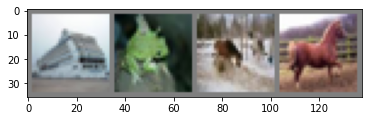

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_out_channels = 32
        self.pooling_size = 4
        self.fc_input_size = self.pooling_size * self.pooling_size * self.num_out_channels
        self.block_head = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.num_out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(self.num_out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=self.num_out_channels, out_channels=self.num_out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(self.num_out_channels)
        )
        self.conv1x1 = nn.Conv2d(in_channels=3, out_channels=self.num_out_channels, kernel_size=1)
        self.block_end = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(self.num_out_channels // self.pooling_size)
        )
        self.fc = nn.Linear(in_features=self.fc_input_size, out_features=n_classes)

    def forward(self, x):
        out = self.block_head(x) + self.conv1x1(x)
        out = self.block_end(out)
        out = self.fc(out.reshape(x.shape[0], self.fc_input_size))
        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (block_head): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1x1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (block_end): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [19]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    criterion = nn.CrossEntropyLoss()

    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        out = model(data)
        loss = criterion(out, target)
        loss_log.append(loss.item())
        acc = (torch.argmax(out, dim=1) == target).sum() / target.shape[0]
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = nn.CrossEntropyLoss()

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()
        acc = (torch.argmax(out, dim=1) == target).sum() / target.shape[0]
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [17]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4832047791759972, train acc: 0.47105967617122085
 val loss: 1.3215617798744363, val acc: 0.5400265957446808

Epoch 1
 train loss: 1.1914361291437305, train acc: 0.5801979956068984
 val loss: 1.1603286563081945, val acc: 0.5981826241980208

Epoch 2
 train loss: 1.0690497017211844, train acc: 0.6273872095008655
 val loss: 1.1100613020836039, val acc: 0.6091755319148936

Epoch 3
 train loss: 0.9969608678024473, train acc: 0.6535444960297788
 val loss: 1.037661333033379, val acc: 0.6352171986661059

Epoch 4
 train loss: 0.9562261329054614, train acc: 0.6692021416135854
 val loss: 0.9670814775406046, val acc: 0.6607269503968827

Epoch 5
 train loss: 0.9328376986426888, train acc: 0.679554877268113
 val loss: 0.9435645633555473, val acc: 0.6761746454746165

Epoch 6
 train loss: 0.910596853254918, train acc: 0.6844435558676502
 val loss: 0.9491855390528415, val acc: 0.6703235816448293

Epoch 7
 train loss: 0.8787855010145978, train acc: 0.6964816205898194
 val loss: 0.8

Посчитайте точность на тестовой выборке:

In [18]:
test_loss, test_acc = test(net, test_loader)

print("test loss:", test_loss, "test acc: ", test_acc)

test loss: 0.9267769501467419, test acc: 0.6806329617834395


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [20]:
import seaborn as sns

train_loss = []
train_acc = []

for i in range(20):
    n = len(train_loader.dataset) // 64 + 1
    train_loss.append(np.mean(train_loss_log[i*n: (i+1)*n]))
    train_acc.append(np.mean(train_acc_log[i*n: (i+1)*n]))

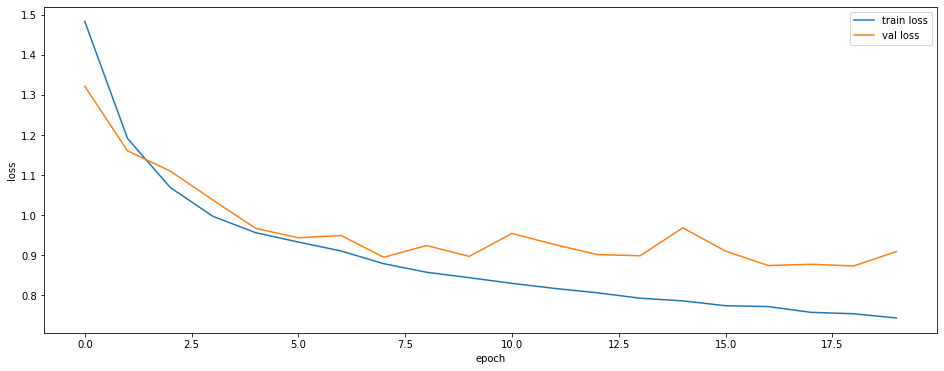

In [22]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=train_loss)
sns.lineplot(data=val_loss_log)

plt.legend(['train loss', 'val loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

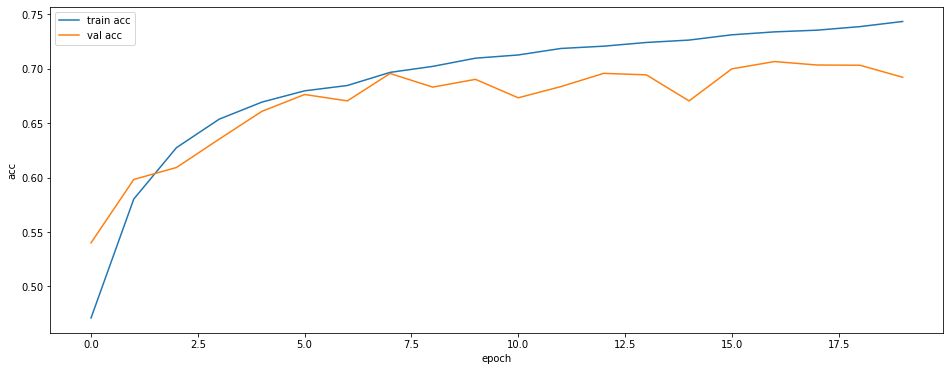

In [23]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=train_acc_mean)
sns.lineplot(data=val_acc_log)

plt.legend(['train acc', 'val acc'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [24]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch  0
 train loss:  1.5153399468339994 train acc:  0.4600662705667276
 val loss:  1.2986220372484085 val acc:  0.5404255319148936 

Epoch  1
 train loss:  1.2107407859300128 train acc:  0.5724854727549789
 val loss:  1.151879294375156 val acc:  0.6016179078436913 

Epoch  2
 train loss:  1.0761517398536096 train acc:  0.6279136197440585
 val loss:  1.0332611690176294 val acc:  0.6465647164811479 

Epoch  3
 train loss:  1.0006633676602157 train acc:  0.650965493710429
 val loss:  1.014372114171373 val acc:  0.6378102837724888 

Epoch  4
 train loss:  0.9609161492239623 train acc:  0.6670883390541704
 val loss:  0.9958268041306354 val acc:  0.6632757093044037 

Epoch  5
 train loss:  0.9338320818418123 train acc:  0.6789346109578552
 val loss:  0.9473091693634682 val acc:  0.6718085106382978 

Epoch  6
 train loss:  0.9089976022840636 train acc:  0.6841538260798131
 val loss:  0.9768780946731568 val acc:  0.6597739361702127 

Epoch  7
 train loss:  0.8932875464559691 train acc:  0.68

Посчитайте точность на тестовой выборке:

In [25]:
test_loss, test_acc = test(net, test_loader)

print("test loss:", test_loss, "test acc: ", test_acc)

test loss: 0.8318327754546123 test acc:  0.7133757961783439


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [26]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch  0
 train loss:  1.830104339711191 train acc:  0.3620192935959295
 val loss:  1.6224058257772567 val acc:  0.43459663124794656 

Epoch  1
 train loss:  1.5389964349527028 train acc:  0.4606538914021452
 val loss:  1.4501713580273567 val acc:  0.48792109933305294 

Epoch  2
 train loss:  1.4157291258492897 train acc:  0.4998000457038391
 val loss:  1.3671086930214091 val acc:  0.5189494680851063 

Epoch  3
 train loss:  1.344762622765257 train acc:  0.5289729695215521
 val loss:  1.3192948711679338 val acc:  0.5386746454746165 

Epoch  4
 train loss:  1.2910120941603205 train acc:  0.5453488182760026
 val loss:  1.2630837105690165 val acc:  0.5503102837724888 

Epoch  5
 train loss:  1.2402602802464906 train acc:  0.5663276965265083
 val loss:  1.2341899278316093 val acc:  0.5674202127659574 

Epoch  6
 train loss:  1.1977650373901703 train acc:  0.5808549882942842
 val loss:  1.1747797293865934 val acc:  0.5869902482692232 

Epoch  7
 train loss:  1.1615552623267584 train acc:  0

In [27]:
test_loss, test_acc = test(net, test_loader)

print("test loss:", test_loss, "test acc: ", test_acc)

test loss: 0.9902330781244169 test acc:  0.6499800955414012


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

**Взято с сайта с документацией торча:**

*   [ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR)

Decays the learning rate of each parameter group by gamma every epoch. When last_epoch=-1, sets initial lr as lr.

*   [CosineAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR)

Set the learning rate of each parameter group using a cosine annealing schedule, where ηmaxηmax​ is set to the initial lr and TcurTcur​ is the number of epochs since the last restart in SGDR. When last_epoch=-1, sets initial lr as lr.

*   [CyclicLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CyclicLR.html#torch.optim.lr_scheduler.CyclicLR)

Sets the learning rate of each parameter group according to cyclical learning rate policy (CLR). The policy cycles the learning rate between two boundaries with a constant frequency, as detailed in the paper Cyclical Learning Rates for Training Neural Networks. The distance between the two boundaries can be scaled on a per-iteration or per-cycle basis.

In [28]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.0001)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch  0
 train loss:  1.4890599635445003 train acc:  0.46881529127657956
 val loss:  1.3405401584949899 val acc:  0.5408909574468085 

Epoch  1
 train loss:  1.2532804891657785 train acc:  0.5628264560559986
 val loss:  1.2547499808859317 val acc:  0.5583998228641267 

Epoch  2
 train loss:  1.246628472312495 train acc:  0.5628958279079668
 val loss:  1.2599737431140656 val acc:  0.557535461161999 

Epoch  3
 train loss:  1.2453565176923707 train acc:  0.5647525463723178
 val loss:  1.2558841002748367 val acc:  0.5574024824385947 

Epoch  4
 train loss:  1.2456487600284696 train acc:  0.5646260447214465
 val loss:  1.257869887098353 val acc:  0.5578679079705097 

Epoch  5
 train loss:  1.2452777910711996 train acc:  0.564340395726931
 val loss:  1.256316615165548 val acc:  0.5578679079705097 

Epoch  6
 train loss:  1.245443924035625 train acc:  0.56459339913764
 val loss:  1.2685522738923418 val acc:  0.5556737590343395 

Epoch  7
 train loss:  1.2448366707160226 train acc:  0.566127

In [29]:
test_loss, test_acc = test(net, test_loader)

print("test loss:", test_loss, "test acc: ", test_acc)

test loss: 1.2422700801472755 test acc:  0.5648885350318471


In [30]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_acc_log))
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch  0
 train loss:  1.511412029728375 train acc:  0.46333899195059125
 val loss:  1.251205221896476 val acc:  0.5532358156873824 

Epoch  1
 train loss:  1.2044876067468409 train acc:  0.5778067054216779
 val loss:  1.1264173867854665 val acc:  0.6051196808510638 

Epoch  2
 train loss:  1.080871874933051 train acc:  0.6223271416135854
 val loss:  1.0895118097041516 val acc:  0.6250443263256803 

Epoch  3
 train loss:  1.0134823236212651 train acc:  0.6492189540505627
 val loss:  1.0020035497685695 val acc:  0.6536790781832756 

Epoch  4
 train loss:  0.9781856936772083 train acc:  0.6596614651967664
 val loss:  1.0006434737367833 val acc:  0.6574911348363186 

Epoch  5
 train loss:  0.9429608958294884 train acc:  0.6711976038908392
 val loss:  1.00208991842067 val acc:  0.6453235816448293 

Epoch  6
 train loss:  0.9232829787395554 train acc:  0.6800282385057244
 val loss:  0.9764430378345733 val acc:  0.6602615249917863 

Epoch  7
 train loss:  0.9070647823091399 train acc:  0.683

In [31]:
test_loss, test_acc = test(net, test_loader)

print("test loss:", test_loss, "test acc: ", test_acc)

test loss: 0.9061991967213382 test acc:  0.6880971337579618


In [32]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch  0
 train loss:  1.815716619901291 train acc:  0.3651859166962137
 val loss:  1.617500481199711 val acc:  0.4294991135597229 

Epoch  1
 train loss:  1.5191962174131404 train acc:  0.46836233356970974
 val loss:  1.4326274663844007 val acc:  0.49408244680851066 

Epoch  2
 train loss:  1.3994034829479685 train acc:  0.505292667876214
 val loss:  1.3515630691609484 val acc:  0.5266843972053934 

Epoch  3
 train loss:  1.327928144055703 train acc:  0.5331312026794476
 val loss:  1.3077015491242105 val acc:  0.5410460993330529 

Epoch  4
 train loss:  1.2821266457193294 train acc:  0.5493356621461551
 val loss:  1.2508140678101398 val acc:  0.5554742908224146 

Epoch  5
 train loss:  1.2398838326743578 train acc:  0.5645117851236403
 val loss:  1.2234463714538737 val acc:  0.5726063829787233 

Epoch  6
 train loss:  1.199711681284024 train acc:  0.5792512732406421
 val loss:  1.1811309596325488 val acc:  0.5873448582405739 

Epoch  7
 train loss:  1.1664904924807644 train acc:  0.58

In [33]:
test_loss, test_acc = test(net, test_loader)

print("test loss:", test_loss, "test acc: ", test_acc)

test loss: 0.9229190782376915 test acc:  0.6836186305732485


Your answers here: я бы не сказал что 3 приведеных метода хороши, но из них лучше всего работает CosineAnnealingLR.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

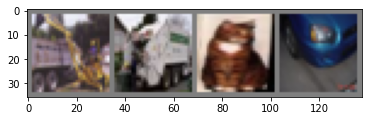

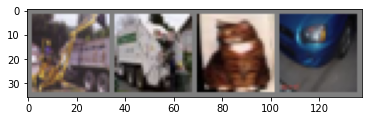

In [35]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [36]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch  0
 train loss:  1.4815949700650175 train acc:  0.4705577501431244
 val loss:  1.279400632482894 val acc:  0.5402482269926274 

Epoch  1
 train loss:  1.1865220857712644 train acc:  0.5833197310158278
 val loss:  1.123468843673138 val acc:  0.6061391845662543 

Epoch  2
 train loss:  1.0565354845859452 train acc:  0.6312230673960837
 val loss:  1.044895735192806 val acc:  0.6374556739279564 

Epoch  3
 train loss:  0.9950120626681466 train acc:  0.652585531501491
 val loss:  0.9948244039048539 val acc:  0.6607712765957446 

Epoch  4
 train loss:  0.9539113873973407 train acc:  0.6682799034624257
 val loss:  1.0005493470963012 val acc:  0.6533244680851064 

Epoch  5
 train loss:  0.9181433409397955 train acc:  0.6830561178475891
 val loss:  0.9133145530173119 val acc:  0.684064716481148 

Epoch  6
 train loss:  0.898155661997891 train acc:  0.6906503004173474
 val loss:  0.9815579959686767 val acc:  0.6576

Посчитайте точность на тестовой выборке:

In [37]:
test_loss, test_acc = test(net, test_loader)

print("test loss:", test_loss, "test acc: ", test_acc)

test loss: 0.7905462241856156 test acc:  0.7294984076433121


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

**Взято с сайта с документацией торча:**

*   [RandomCrop](https://pytorch.org/vision/0.11/transforms.html)

Crop the given image at a random location. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions, but if non-constant padding is used, the input is expected to have at most 2 leading dimensions

*   [GaussianBlur](https://pytorch.org/vision/0.11/transforms.html)

Blurs image with randomly chosen Gaussian blur. If the image is torch Tensor, it is expected to have […, C, H, W] shape, where … means an arbitrary number of leading dimensions.

In [38]:
transform = transforms.Compose(
        [transforms.RandomCrop(28),
         transforms.Resize(32),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch  0
 train loss:  1.557539773161712 train acc:  0.4430252677561814
 val loss:  1.3556366261015547 val acc:  0.512876773134191 

Epoch  1
 train loss:  1.2614650315514866 train acc:  0.5575133847580096
 val loss:  1.1934430094475441 val acc:  0.5796542553191489 

Epoch  2
 train loss:  1.1617990543681045 train acc:  0.5944192348494173
 val loss:  1.2324736290789664 val acc:  0.5867464539852548 

Epoch  3
 train loss:  1.1119461777659176 train acc:  0.6121294725093807
 val loss:  1.0850783799556976 val acc:  0.623160461161999 

Epoch  4
 train loss:  1.068177495621676 train acc:  0.6289215527025394
 val loss:  1.1526488709957041 val acc:  0.6011746454746165 

Epoch  5
 train loss:  1.0428315039308678 train acc:  0.6357322408250743
 val loss:  1.1114333277053021 val acc:  0.6148271276595745 

Epoch  6
 train loss:  1.0169187920403 train acc:  0.6452647558731832
 val loss:  1.0350985037519578 val acc:  0.63264

In [39]:
test_loss, test_acc = test(net, test_loader)

print("test loss:", test_loss, "test acc: ", test_acc)

test loss: 1.218393764298433 test acc:  0.6311703821656051


In [40]:
transform = transforms.Compose(
        [transforms.GaussianBlur(kernel_size=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch  0
 train loss:  1.5551030513791324 train acc:  0.4464204101065613
 val loss:  1.3848821878433228 val acc:  0.5024822695458189 

Epoch  1
 train loss:  1.287215516379808 train acc:  0.5459037934186471
 val loss:  1.1794965186017625 val acc:  0.5850398936170212 

Epoch  2
 train loss:  1.1813686150083593 train acc:  0.585792635215048
 val loss:  1.1520045678666297 val acc:  0.5941046100981692 

Epoch  3
 train loss:  1.1226601743393014 train acc:  0.6087710564271623
 val loss:  1.1043768705205714 val acc:  0.6156693263256804 

Epoch  4
 train loss:  1.0772162087438748 train acc:  0.6242858775137111
 val loss:  1.1373462831720393 val acc:  0.6076241135597229 

Epoch  5
 train loss:  1.0502175723612854 train acc:  0.6306558500914077
 val loss:  1.0966086453579842 val acc:  0.6153812057160316 

Epoch  6
 train loss:  1.0240398702063551 train acc:  0.6424082659280278
 val loss:  1.0266612971082647 val acc:  0.

In [41]:
test_loss, test_acc = test(net, test_loader)

print("test loss:", test_loss, "test acc: ", test_acc)

test loss: 0.9428682862573369 test acc:  0.6859076433121019


Your answers here: В данном задании, в отличии от предыдущего, рассматриваемые варианты показали себя очень недурственно.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>